In [211]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs
import numpy as np
import matplotlib.pyplot as plt

In [212]:
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 100

In [242]:
train_loader, test_loader = mnist(batch_size=32, valid=0)

In [26]:
pytorch_mnist_data = train_loader.dataset.train_data.numpy().reshape(60000, -1)
pytorch_mnist_target = train_loader.dataset.train_labels.numpy().reshape(60000, -1)

test_pytorch_mnist_data = test_loader.dataset.test_data.numpy().reshape(10000, -1)
test_pytorch_mnist_target = test_loader.dataset.test_labels.numpy().reshape(10000, -1)

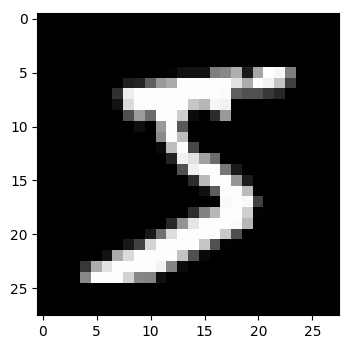

In [5]:
plt.imshow(pytorch_mnist_data.reshape(-1, 28, 28)[0])

In [7]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)

print('KNN score: %f' % knn.fit(pytorch_mnist_data, 
                                pytorch_mnist_target.ravel()).score(test_pytorch_mnist_data, 
                                                                    test_pytorch_mnist_target.ravel()))
test_preds = knn.predict(test_pytorch_mnist_data)

KNN score: 0.966500


In [8]:
np.where(test_preds != test_pytorch_mnist_target.ravel())

(array([  33,   43,   61,   77,  115,  195,  241,  247,  300,  318,  320,
         321,  341,  358,  381,  444,  445,  447,  456,  464,  479,  495,
         542,  551,  565,  582,  583,  628,  635,  646,  659,  667,  691,
         707,  740,  760,  791,  839,  844,  924,  938,  939,  947,  951,
         957,  965, 1014, 1039, 1062, 1068, 1107, 1112, 1173, 1181, 1184,
        1192, 1226, 1242, 1247, 1260, 1283, 1289, 1299, 1319, 1326, 1364,
        1378, 1393, 1415, 1425, 1433, 1465, 1500, 1522, 1530, 1553, 1559,
        1681, 1695, 1701, 1709, 1716, 1717, 1721, 1737, 1754, 1774, 1782,
        1790, 1813, 1823, 1850, 1865, 1878, 1901, 1955, 1968, 1984, 2043,
        2044, 2052, 2053, 2063, 2070, 2082, 2093, 2098, 2109, 2118, 2129,
        2130, 2135, 2168, 2177, 2182, 2185, 2186, 2189, 2197, 2224, 2293,
        2299, 2325, 2339, 2387, 2393, 2406, 2422, 2426, 2437, 2447, 2454,
        2462, 2488, 2533, 2582, 2597, 2607, 2648, 2654, 2730, 2771, 2896,
        2927, 2939, 2952, 3005, 3060, 

Prediction is 0
But target is 4


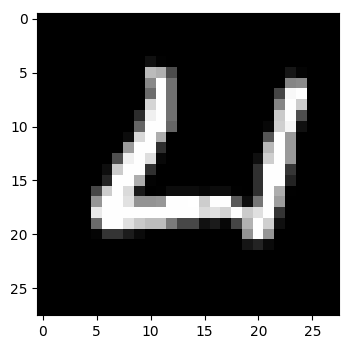

In [9]:
plt.imshow(test_pytorch_mnist_data[33].reshape(28, 28))
print('Prediction is {0}'.format(test_preds[33]))
print('But target is {0}'.format(test_pytorch_mnist_target[33][0]))

In [10]:
train_preds = knn.predict(pytorch_mnist_data)

Prediction is 0
But target is 9


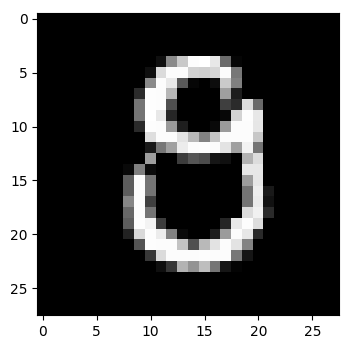

In [11]:
plt.imshow(pytorch_mnist_data[80].reshape(28, 28))
print('Prediction is {0}'.format(train_preds[80]))
print('But target is {0}'.format(pytorch_mnist_target[80][0]))

In [243]:
def get_allowed_indices(preds, target, n_fine_samples=None, use_hard=True):
    hard_samples = np.where(preds != target.ravel())[0]
    print("Total hard samples: {0}".format(hard_samples.shape))
    
    # sample fine samples
    import random
    
    if n_fine_samples is None:
        n_fine_samples = len(hard_samples)

    mask = ~np.isin(list(range(1, len(target))), hard_samples)
    fine_samples = random.sample(list(np.where(mask)[0]), n_fine_samples)
    
    if use_hard:
        return np.concatenate([fine_samples, hard_samples])
    else:
        return fine_samples

In [244]:
allowed_indices_train = get_allowed_indices(train_preds, pytorch_mnist_target,
                                           use_hard=False, n_fine_samples=10000)
allowed_indices_test = get_allowed_indices(test_preds, test_pytorch_mnist_target, 
                                           n_fine_samples=100)

Total hard samples: (1500,)
Total hard samples: (335,)


In [245]:
train_loader.dataset.train_data = train_loader.dataset.train_data[allowed_indices_train, :, :]
train_loader.dataset.train_labels = train_loader.dataset.train_labels[allowed_indices_train]

In [246]:
train_loader.dataset.train_data.shape

torch.Size([10000, 28, 28])

In [247]:
test_loader.dataset.test_data = test_loader.dataset.test_data[allowed_indices_test, :, :]
test_loader.dataset.test_labels = test_loader.dataset.test_labels[allowed_indices_test]

In [248]:
test_loader.dataset.test_data.shape

torch.Size([435, 28, 28])

In [249]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-5, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(256)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [250]:
def train(epoch, models, train_log):
    train_size = len(train_loader.sampler)
    train_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
            train_loss[k] += model.loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
    for k in models:
        train_loss[k] /= train_size
    
    correct_pct = {k: 100. * correct[k] / train_size for k in correct}
    
    if train_log is not None:
        for k in models:
            train_log[k].append((train_loss[k], correct_pct[k]))

In [251]:
models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [252]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [253]:
for epoch in range(1, 501):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [0/10000 (0%)]	Losses default: 73.307365 bn: 74.220161 drop: 74.202301 both: 74.486618
Train Epoch: 1 [6400/10000 (64%)]	Losses default: 62.982056 bn: 60.626015 drop: 66.485214 both: 65.249321
Train Epoch: 1 [5008/10000 (100%)]	Losses default: 28.433533 bn: 28.074934 drop: 30.911798 both: 30.251032
Test set:
default: Loss: 2.1041	Accuracy: 114/435 (26%)
bn: Loss: 2.0900	Accuracy: 112/435 (25%)
drop: Loss: 2.1541	Accuracy: 108/435 (24%)
both: Loss: 2.1647	Accuracy: 97/435 (22%)

Train Epoch: 2 [0/10000 (0%)]	Losses default: 54.208248 bn: 52.072182 drop: 60.052361 both: 57.625401
Train Epoch: 2 [6400/10000 (64%)]	Losses default: 44.197903 bn: 44.100918 drop: 52.696384 both: 51.682026
Train Epoch: 2 [5008/10000 (100%)]	Losses default: 19.673931 bn: 20.207668 drop: 24.191843 both: 23.777960
Test set:
default: Loss: 1.9506	Accuracy: 130/435 (29%)
bn: Loss: 1.9672	Accuracy: 113/435 (25%)
drop: Loss: 2.0116	Accuracy: 112/435 (25%)
both: Loss: 2.0410	Accuracy: 114/435 (26%)

Tra

Train Epoch: 18 [6400/10000 (64%)]	Losses default: 13.230977 bn: 13.213129 drop: 15.999121 both: 15.550856
Train Epoch: 18 [5008/10000 (100%)]	Losses default: 3.668091 bn: 4.024107 drop: 4.030406 both: 4.962390
Test set:
default: Loss: 1.8922	Accuracy: 174/435 (40%)
bn: Loss: 1.8731	Accuracy: 173/435 (39%)
drop: Loss: 1.8662	Accuracy: 174/435 (40%)
both: Loss: 1.8853	Accuracy: 166/435 (38%)

Train Epoch: 19 [0/10000 (0%)]	Losses default: 13.031469 bn: 11.397382 drop: 14.773119 both: 13.323713
Train Epoch: 19 [6400/10000 (64%)]	Losses default: 7.739454 bn: 11.055998 drop: 10.169283 both: 14.993866
Train Epoch: 19 [5008/10000 (100%)]	Losses default: 1.428722 bn: 2.677168 drop: 1.308407 both: 3.095884
Test set:
default: Loss: 1.8945	Accuracy: 174/435 (40%)
bn: Loss: 1.8393	Accuracy: 178/435 (40%)
drop: Loss: 1.8923	Accuracy: 170/435 (39%)
both: Loss: 1.8612	Accuracy: 177/435 (40%)

Train Epoch: 20 [0/10000 (0%)]	Losses default: 5.353029 bn: 5.189169 drop: 6.033262 both: 7.082653
Train Epo

Train Epoch: 35 [6400/10000 (64%)]	Losses default: 5.253044 bn: 5.019308 drop: 6.262514 both: 5.950562
Train Epoch: 35 [5008/10000 (100%)]	Losses default: 0.717676 bn: 0.881697 drop: 1.289745 both: 1.019398
Test set:
default: Loss: 1.8733	Accuracy: 191/435 (43%)
bn: Loss: 1.7197	Accuracy: 204/435 (46%)
drop: Loss: 1.8900	Accuracy: 184/435 (42%)
both: Loss: 1.7692	Accuracy: 202/435 (46%)

Train Epoch: 36 [0/10000 (0%)]	Losses default: 1.634107 bn: 1.602242 drop: 2.824200 both: 1.731525
Train Epoch: 36 [6400/10000 (64%)]	Losses default: 10.766268 bn: 9.525747 drop: 11.770544 both: 9.913122
Train Epoch: 36 [5008/10000 (100%)]	Losses default: 2.615971 bn: 5.193194 drop: 4.707149 both: 5.748676
Test set:
default: Loss: 1.8692	Accuracy: 196/435 (45%)
bn: Loss: 1.7454	Accuracy: 203/435 (46%)
drop: Loss: 1.8920	Accuracy: 185/435 (42%)
both: Loss: 1.8233	Accuracy: 194/435 (44%)

Train Epoch: 37 [0/10000 (0%)]	Losses default: 2.570446 bn: 3.157264 drop: 4.665883 both: 3.341711
Train Epoch: 37 [6

Train Epoch: 52 [6400/10000 (64%)]	Losses default: 2.298136 bn: 3.322553 drop: 3.011210 both: 3.937904
Train Epoch: 52 [5008/10000 (100%)]	Losses default: 5.376155 bn: 4.914970 drop: 6.187384 both: 5.261096
Test set:
default: Loss: 1.8176	Accuracy: 211/435 (48%)
bn: Loss: 1.5807	Accuracy: 235/435 (54%)
drop: Loss: 1.8880	Accuracy: 199/435 (45%)
both: Loss: 1.6846	Accuracy: 220/435 (50%)

Train Epoch: 53 [0/10000 (0%)]	Losses default: 2.013737 bn: 2.629963 drop: 3.012416 both: 2.711929
Train Epoch: 53 [6400/10000 (64%)]	Losses default: 4.326522 bn: 2.252775 drop: 8.538131 both: 5.285530
Train Epoch: 53 [5008/10000 (100%)]	Losses default: 0.320724 bn: 0.302230 drop: 0.402928 both: 0.835149
Test set:
default: Loss: 1.8049	Accuracy: 207/435 (47%)
bn: Loss: 1.5743	Accuracy: 236/435 (54%)
drop: Loss: 1.8657	Accuracy: 206/435 (47%)
both: Loss: 1.6602	Accuracy: 218/435 (50%)

Train Epoch: 54 [0/10000 (0%)]	Losses default: 2.693590 bn: 1.148850 drop: 3.463472 both: 1.691887
Train Epoch: 54 [640

Train Epoch: 69 [6400/10000 (64%)]	Losses default: 1.524224 bn: 2.348182 drop: 2.879504 both: 4.737577
Train Epoch: 69 [5008/10000 (100%)]	Losses default: 2.118199 bn: 1.261910 drop: 2.145900 both: 3.777577
Test set:
default: Loss: 1.7528	Accuracy: 211/435 (48%)
bn: Loss: 1.5150	Accuracy: 244/435 (56%)
drop: Loss: 1.7907	Accuracy: 213/435 (48%)
both: Loss: 1.5791	Accuracy: 236/435 (54%)

Train Epoch: 70 [0/10000 (0%)]	Losses default: 1.069898 bn: 1.048279 drop: 1.890254 both: 1.403500
Train Epoch: 70 [6400/10000 (64%)]	Losses default: 10.379786 bn: 9.023135 drop: 13.168775 both: 10.656394
Train Epoch: 70 [5008/10000 (100%)]	Losses default: 0.942183 bn: 1.220201 drop: 3.157759 both: 2.027027
Test set:
default: Loss: 1.7402	Accuracy: 219/435 (50%)
bn: Loss: 1.5125	Accuracy: 253/435 (58%)
drop: Loss: 1.8477	Accuracy: 204/435 (46%)
both: Loss: 1.6267	Accuracy: 227/435 (52%)

Train Epoch: 71 [0/10000 (0%)]	Losses default: 2.229577 bn: 6.891466 drop: 2.817776 both: 10.546998
Train Epoch: 71 

Train Epoch: 86 [6400/10000 (64%)]	Losses default: 1.166444 bn: 2.093021 drop: 2.807581 both: 2.154331
Train Epoch: 86 [5008/10000 (100%)]	Losses default: 1.041284 bn: 0.429693 drop: 1.210591 both: 0.835488
Test set:
default: Loss: 1.6978	Accuracy: 226/435 (51%)
bn: Loss: 1.5261	Accuracy: 262/435 (60%)
drop: Loss: 1.7666	Accuracy: 220/435 (50%)
both: Loss: 1.6318	Accuracy: 239/435 (54%)

Train Epoch: 87 [0/10000 (0%)]	Losses default: 1.150375 bn: 1.358470 drop: 2.516666 both: 1.918923
Train Epoch: 87 [6400/10000 (64%)]	Losses default: 0.654917 bn: 0.186264 drop: 1.585558 both: 0.503330
Train Epoch: 87 [5008/10000 (100%)]	Losses default: 0.286434 bn: 0.887421 drop: 0.914972 both: 1.163035
Test set:
default: Loss: 1.7002	Accuracy: 226/435 (51%)
bn: Loss: 1.5044	Accuracy: 259/435 (59%)
drop: Loss: 1.7754	Accuracy: 222/435 (51%)
both: Loss: 1.5863	Accuracy: 245/435 (56%)

Train Epoch: 88 [0/10000 (0%)]	Losses default: 1.243534 bn: 2.415189 drop: 1.820431 both: 2.889461
Train Epoch: 88 [640

Train Epoch: 103 [6400/10000 (64%)]	Losses default: 0.645481 bn: 0.480461 drop: 1.109838 both: 0.650802
Train Epoch: 103 [5008/10000 (100%)]	Losses default: 1.415324 bn: 2.805737 drop: 4.273717 both: 3.250946
Test set:
default: Loss: 1.7115	Accuracy: 228/435 (52%)
bn: Loss: 1.5573	Accuracy: 256/435 (58%)
drop: Loss: 1.7801	Accuracy: 224/435 (51%)
both: Loss: 1.5751	Accuracy: 254/435 (58%)

Train Epoch: 104 [0/10000 (0%)]	Losses default: 0.352807 bn: 0.225499 drop: 1.050524 both: 0.992540
Train Epoch: 104 [6400/10000 (64%)]	Losses default: 0.611521 bn: 0.630025 drop: 0.871770 both: 0.708127
Train Epoch: 104 [5008/10000 (100%)]	Losses default: 0.277340 bn: 1.784350 drop: 0.663448 both: 1.926626
Test set:
default: Loss: 1.7002	Accuracy: 231/435 (53%)
bn: Loss: 1.5612	Accuracy: 262/435 (60%)
drop: Loss: 1.7369	Accuracy: 230/435 (52%)
both: Loss: 1.5966	Accuracy: 247/435 (56%)

Train Epoch: 105 [0/10000 (0%)]	Losses default: 1.583032 bn: 0.665322 drop: 3.123333 both: 2.053091
Train Epoch: 1

Train Epoch: 120 [6400/10000 (64%)]	Losses default: 0.201796 bn: 0.283625 drop: 0.481833 both: 0.425556
Train Epoch: 120 [5008/10000 (100%)]	Losses default: 0.254360 bn: 1.730716 drop: 0.835297 both: 2.224844
Test set:
default: Loss: 1.7570	Accuracy: 238/435 (54%)
bn: Loss: 1.6437	Accuracy: 260/435 (59%)
drop: Loss: 1.7324	Accuracy: 235/435 (54%)
both: Loss: 1.5742	Accuracy: 259/435 (59%)

Train Epoch: 121 [0/10000 (0%)]	Losses default: 0.259999 bn: 0.104513 drop: 2.396369 both: 0.171102
Train Epoch: 121 [6400/10000 (64%)]	Losses default: 0.657311 bn: 1.172786 drop: 2.980091 both: 1.198200
Train Epoch: 121 [5008/10000 (100%)]	Losses default: 0.362505 bn: 0.458297 drop: 1.565451 both: 0.650536
Test set:
default: Loss: 1.7748	Accuracy: 232/435 (53%)
bn: Loss: 1.6599	Accuracy: 261/435 (60%)
drop: Loss: 1.8076	Accuracy: 235/435 (54%)
both: Loss: 1.6421	Accuracy: 252/435 (57%)

Train Epoch: 122 [0/10000 (0%)]	Losses default: 0.356066 bn: 0.219972 drop: 2.435049 both: 0.903329
Train Epoch: 1

Train Epoch: 137 [6400/10000 (64%)]	Losses default: 0.139868 bn: 0.087150 drop: 1.529771 both: 0.401443
Train Epoch: 137 [5008/10000 (100%)]	Losses default: 0.082144 bn: 0.230089 drop: 0.240943 both: 0.247656
Test set:
default: Loss: 1.8630	Accuracy: 242/435 (55%)
bn: Loss: 1.7705	Accuracy: 260/435 (59%)
drop: Loss: 1.8013	Accuracy: 233/435 (53%)
both: Loss: 1.7899	Accuracy: 251/435 (57%)

Train Epoch: 138 [0/10000 (0%)]	Losses default: 0.049469 bn: 0.069240 drop: 0.343351 both: 0.178679
Train Epoch: 138 [6400/10000 (64%)]	Losses default: 0.086237 bn: 0.187379 drop: 0.212327 both: 0.348905
Train Epoch: 138 [5008/10000 (100%)]	Losses default: 0.087078 bn: 0.525024 drop: 0.868363 both: 0.700575
Test set:
default: Loss: 1.8886	Accuracy: 242/435 (55%)
bn: Loss: 1.7348	Accuracy: 266/435 (61%)
drop: Loss: 1.8108	Accuracy: 252/435 (57%)
both: Loss: 1.7308	Accuracy: 251/435 (57%)

Train Epoch: 139 [0/10000 (0%)]	Losses default: 0.090768 bn: 0.104115 drop: 0.753037 both: 0.348639
Train Epoch: 1

Train Epoch: 154 [6400/10000 (64%)]	Losses default: 0.021804 bn: 0.049967 drop: 0.059957 both: 0.069638
Train Epoch: 154 [5008/10000 (100%)]	Losses default: 0.027696 bn: 0.342162 drop: 0.185068 both: 0.239706
Test set:
default: Loss: 2.0425	Accuracy: 246/435 (56%)
bn: Loss: 1.7870	Accuracy: 267/435 (61%)
drop: Loss: 1.8100	Accuracy: 254/435 (58%)
both: Loss: 1.7899	Accuracy: 266/435 (61%)

Train Epoch: 155 [0/10000 (0%)]	Losses default: 0.050028 bn: 0.314440 drop: 0.484060 both: 0.502839
Train Epoch: 155 [6400/10000 (64%)]	Losses default: 0.027286 bn: 0.013083 drop: 0.188179 both: 0.181597
Train Epoch: 155 [5008/10000 (100%)]	Losses default: 0.019167 bn: 0.037779 drop: 0.334510 both: 0.103871
Test set:
default: Loss: 2.0594	Accuracy: 245/435 (56%)
bn: Loss: 1.8185	Accuracy: 262/435 (60%)
drop: Loss: 1.8925	Accuracy: 244/435 (56%)
both: Loss: 1.7815	Accuracy: 265/435 (60%)

Train Epoch: 156 [0/10000 (0%)]	Losses default: 0.038398 bn: 0.401158 drop: 0.337956 both: 0.293129
Train Epoch: 1

Train Epoch: 171 [6400/10000 (64%)]	Losses default: 0.020472 bn: 0.122671 drop: 0.170005 both: 0.205479
Train Epoch: 171 [5008/10000 (100%)]	Losses default: 0.008558 bn: 0.013427 drop: 0.077455 both: 1.298577
Test set:
default: Loss: 2.2527	Accuracy: 249/435 (57%)
bn: Loss: 1.8574	Accuracy: 266/435 (61%)
drop: Loss: 2.0078	Accuracy: 249/435 (57%)
both: Loss: 1.7702	Accuracy: 259/435 (59%)

Train Epoch: 172 [0/10000 (0%)]	Losses default: 0.015850 bn: 0.083023 drop: 0.336327 both: 0.371521
Train Epoch: 172 [6400/10000 (64%)]	Losses default: 0.013570 bn: 0.173961 drop: 0.127983 both: 0.129776
Train Epoch: 172 [5008/10000 (100%)]	Losses default: 0.006355 bn: 1.072364 drop: 0.051801 both: 0.412159
Test set:
default: Loss: 2.2576	Accuracy: 253/435 (58%)
bn: Loss: 1.8773	Accuracy: 262/435 (60%)
drop: Loss: 2.0173	Accuracy: 239/435 (54%)
both: Loss: 1.7995	Accuracy: 263/435 (60%)

Train Epoch: 173 [0/10000 (0%)]	Losses default: 0.011228 bn: 0.050560 drop: 0.275083 both: 0.154037
Train Epoch: 1

Train Epoch: 188 [6400/10000 (64%)]	Losses default: 0.002419 bn: 0.257796 drop: 0.077172 both: 0.210110
Train Epoch: 188 [5008/10000 (100%)]	Losses default: 0.004159 bn: 0.056219 drop: 0.111752 both: 0.109951
Test set:
default: Loss: 2.4947	Accuracy: 251/435 (57%)
bn: Loss: 1.9585	Accuracy: 268/435 (61%)
drop: Loss: 2.0214	Accuracy: 246/435 (56%)
both: Loss: 1.9775	Accuracy: 264/435 (60%)

Train Epoch: 189 [0/10000 (0%)]	Losses default: 0.002769 bn: 0.027221 drop: 0.056976 both: 0.052281
Train Epoch: 189 [6400/10000 (64%)]	Losses default: 0.003119 bn: 0.011944 drop: 0.188149 both: 0.095783
Train Epoch: 189 [5008/10000 (100%)]	Losses default: 0.007264 bn: 2.867479 drop: 0.302502 both: 5.102022
Test set:
default: Loss: 2.5071	Accuracy: 253/435 (58%)
bn: Loss: 1.9980	Accuracy: 263/435 (60%)
drop: Loss: 2.0983	Accuracy: 247/435 (56%)
both: Loss: 1.8826	Accuracy: 258/435 (59%)

Train Epoch: 190 [0/10000 (0%)]	Losses default: 0.006362 bn: 0.046225 drop: 0.185719 both: 0.246213
Train Epoch: 1

Train Epoch: 205 [6400/10000 (64%)]	Losses default: 0.002008 bn: 0.065264 drop: 0.067943 both: 1.062938
Train Epoch: 205 [5008/10000 (100%)]	Losses default: 0.000212 bn: 0.007607 drop: 0.015550 both: 0.011247
Test set:
default: Loss: 2.7826	Accuracy: 255/435 (58%)
bn: Loss: 2.0407	Accuracy: 263/435 (60%)
drop: Loss: 2.0958	Accuracy: 255/435 (58%)
both: Loss: 1.8648	Accuracy: 269/435 (61%)

Train Epoch: 206 [0/10000 (0%)]	Losses default: 0.001192 bn: 0.012891 drop: 0.259094 both: 0.110291
Train Epoch: 206 [6400/10000 (64%)]	Losses default: 0.000082 bn: 0.006626 drop: 0.016550 both: 0.017137
Train Epoch: 206 [5008/10000 (100%)]	Losses default: 0.000867 bn: 0.011827 drop: 0.086830 both: 0.031627
Test set:
default: Loss: 2.7722	Accuracy: 256/435 (58%)
bn: Loss: 2.0028	Accuracy: 265/435 (60%)
drop: Loss: 2.1722	Accuracy: 242/435 (55%)
both: Loss: 1.9131	Accuracy: 269/435 (61%)

Train Epoch: 207 [0/10000 (0%)]	Losses default: 0.000448 bn: 0.255404 drop: 0.042549 both: 1.076760
Train Epoch: 2

Train Epoch: 222 [6400/10000 (64%)]	Losses default: 0.000172 bn: 0.033323 drop: 0.094634 both: 0.120724
Train Epoch: 222 [5008/10000 (100%)]	Losses default: 0.000102 bn: 0.043590 drop: 0.017958 both: 0.129247
Test set:
default: Loss: 3.0518	Accuracy: 256/435 (58%)
bn: Loss: 2.0531	Accuracy: 265/435 (60%)
drop: Loss: 2.2947	Accuracy: 242/435 (55%)
both: Loss: 1.9262	Accuracy: 269/435 (61%)

Train Epoch: 223 [0/10000 (0%)]	Losses default: 0.000303 bn: 0.061366 drop: 0.081065 both: 0.840415
Train Epoch: 223 [6400/10000 (64%)]	Losses default: 0.000215 bn: 0.024153 drop: 0.063877 both: 0.250939
Train Epoch: 223 [5008/10000 (100%)]	Losses default: 0.000186 bn: 0.133348 drop: 0.013308 both: 0.026691
Test set:
default: Loss: 3.0474	Accuracy: 256/435 (58%)
bn: Loss: 2.0685	Accuracy: 267/435 (61%)
drop: Loss: 2.1844	Accuracy: 257/435 (59%)
both: Loss: 1.9972	Accuracy: 272/435 (62%)

Train Epoch: 224 [0/10000 (0%)]	Losses default: 0.000158 bn: 0.027489 drop: 0.065333 both: 0.038099
Train Epoch: 2

Train Epoch: 239 [6400/10000 (64%)]	Losses default: 0.000034 bn: 0.084634 drop: 0.013799 both: 0.112059
Train Epoch: 239 [5008/10000 (100%)]	Losses default: 0.000005 bn: 0.021570 drop: 0.000425 both: 0.020033
Test set:
default: Loss: 3.3358	Accuracy: 256/435 (58%)
bn: Loss: 2.1249	Accuracy: 267/435 (61%)
drop: Loss: 2.3150	Accuracy: 252/435 (57%)
both: Loss: 2.0637	Accuracy: 263/435 (60%)

Train Epoch: 240 [0/10000 (0%)]	Losses default: 0.000032 bn: 0.010495 drop: 0.024599 both: 0.042558
Train Epoch: 240 [6400/10000 (64%)]	Losses default: 0.000053 bn: 0.006049 drop: 0.059736 both: 0.033209
Train Epoch: 240 [5008/10000 (100%)]	Losses default: 0.000013 bn: 0.284898 drop: 0.003389 both: 0.022886
Test set:
default: Loss: 3.3655	Accuracy: 256/435 (58%)
bn: Loss: 2.0728	Accuracy: 265/435 (60%)
drop: Loss: 2.3946	Accuracy: 255/435 (58%)
both: Loss: 2.0440	Accuracy: 265/435 (60%)

Train Epoch: 241 [0/10000 (0%)]	Losses default: 0.000054 bn: 0.007706 drop: 0.019274 both: 0.020191
Train Epoch: 2

Train Epoch: 256 [6400/10000 (64%)]	Losses default: 0.000008 bn: 0.008499 drop: 0.042560 both: 0.012634
Train Epoch: 256 [5008/10000 (100%)]	Losses default: 0.000006 bn: 0.027008 drop: 0.002469 both: 0.040222
Test set:
default: Loss: 3.5901	Accuracy: 254/435 (58%)
bn: Loss: 2.1908	Accuracy: 263/435 (60%)
drop: Loss: 2.4031	Accuracy: 265/435 (60%)
both: Loss: 2.1601	Accuracy: 260/435 (59%)

Train Epoch: 257 [0/10000 (0%)]	Losses default: 0.000017 bn: 0.011368 drop: 0.034759 both: 0.072549
Train Epoch: 257 [6400/10000 (64%)]	Losses default: 0.000004 bn: 0.021597 drop: 0.002569 both: 0.038303
Train Epoch: 257 [5008/10000 (100%)]	Losses default: 0.000004 bn: 0.091762 drop: 0.019973 both: 0.280515
Test set:
default: Loss: 3.6117	Accuracy: 258/435 (59%)
bn: Loss: 2.1562	Accuracy: 262/435 (60%)
drop: Loss: 2.5331	Accuracy: 248/435 (57%)
both: Loss: 2.0278	Accuracy: 267/435 (61%)

Train Epoch: 258 [0/10000 (0%)]	Losses default: 0.000008 bn: 0.006398 drop: 0.016671 both: 0.170326
Train Epoch: 2

Train Epoch: 273 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.003452 drop: 0.007021 both: 0.012320
Train Epoch: 273 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.001539 drop: 0.001025 both: 0.245648
Test set:
default: Loss: 3.6945	Accuracy: 258/435 (59%)
bn: Loss: 2.2191	Accuracy: 269/435 (61%)
drop: Loss: 2.5882	Accuracy: 254/435 (58%)
both: Loss: 2.1196	Accuracy: 273/435 (62%)

Train Epoch: 274 [0/10000 (0%)]	Losses default: 0.000002 bn: 0.001842 drop: 0.002879 both: 0.041512
Train Epoch: 274 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.002097 drop: 0.002604 both: 0.014740
Train Epoch: 274 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.009241 drop: 0.012309 both: 0.011122
Test set:
default: Loss: 3.6993	Accuracy: 256/435 (58%)
bn: Loss: 2.1904	Accuracy: 269/435 (61%)
drop: Loss: 2.6301	Accuracy: 248/435 (57%)
both: Loss: 2.0186	Accuracy: 277/435 (63%)

Train Epoch: 275 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.003038 drop: 0.005185 both: 0.008239
Train Epoch: 2

Train Epoch: 290 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.005774 drop: 0.007994 both: 0.012134
Train Epoch: 290 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.025517 drop: 0.006002 both: 0.791007
Test set:
default: Loss: 3.6691	Accuracy: 258/435 (59%)
bn: Loss: 2.2987	Accuracy: 269/435 (61%)
drop: Loss: 2.7122	Accuracy: 252/435 (57%)
both: Loss: 2.1089	Accuracy: 275/435 (63%)

Train Epoch: 291 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.014843 drop: 0.003779 both: 0.046501
Train Epoch: 291 [6400/10000 (64%)]	Losses default: 0.000002 bn: 0.059078 drop: 0.001479 both: 0.089711
Train Epoch: 291 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.021073 drop: 0.004981 both: 0.027645
Test set:
default: Loss: 3.6359	Accuracy: 257/435 (59%)
bn: Loss: 2.3380	Accuracy: 262/435 (60%)
drop: Loss: 2.6304	Accuracy: 257/435 (59%)
both: Loss: 2.1737	Accuracy: 274/435 (62%)

Train Epoch: 292 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.002369 drop: 0.007584 both: 0.004857
Train Epoch: 2

Train Epoch: 307 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.011512 drop: 0.018881 both: 0.054110
Train Epoch: 307 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.262568 drop: 0.001402 both: 0.585270
Test set:
default: Loss: 3.5804	Accuracy: 258/435 (59%)
bn: Loss: 2.3018	Accuracy: 266/435 (61%)
drop: Loss: 2.7451	Accuracy: 258/435 (59%)
both: Loss: 2.1089	Accuracy: 278/435 (63%)

Train Epoch: 308 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.158752 drop: 0.003663 both: 0.139091
Train Epoch: 308 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.071232 drop: 0.002460 both: 0.027493
Train Epoch: 308 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.001856 drop: 0.000753 both: 0.004048
Test set:
default: Loss: 3.5676	Accuracy: 256/435 (58%)
bn: Loss: 2.2739	Accuracy: 268/435 (61%)
drop: Loss: 2.7439	Accuracy: 250/435 (57%)
both: Loss: 2.2753	Accuracy: 264/435 (60%)

Train Epoch: 309 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.021310 drop: 0.004685 both: 0.051038
Train Epoch: 3

Train Epoch: 324 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.000466 drop: 0.001986 both: 0.001579
Train Epoch: 324 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.011909 drop: 0.002758 both: 0.030882
Test set:
default: Loss: 3.5141	Accuracy: 260/435 (59%)
bn: Loss: 2.2800	Accuracy: 268/435 (61%)
drop: Loss: 2.9120	Accuracy: 256/435 (58%)
both: Loss: 2.2469	Accuracy: 271/435 (62%)

Train Epoch: 325 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.001504 drop: 0.002504 both: 0.005225
Train Epoch: 325 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.003313 drop: 0.001531 both: 0.007139
Train Epoch: 325 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.013157 drop: 0.001125 both: 0.014983
Test set:
default: Loss: 3.5113	Accuracy: 257/435 (59%)
bn: Loss: 2.3328	Accuracy: 264/435 (60%)
drop: Loss: 2.7975	Accuracy: 258/435 (59%)
both: Loss: 2.2508	Accuracy: 265/435 (60%)

Train Epoch: 326 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.010754 drop: 0.004149 both: 0.019806
Train Epoch: 3

Train Epoch: 341 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.004629 drop: 0.001882 both: 0.002362
Train Epoch: 341 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.002136 drop: 0.000034 both: 0.522681
Test set:
default: Loss: 3.4644	Accuracy: 260/435 (59%)
bn: Loss: 2.3698	Accuracy: 270/435 (62%)
drop: Loss: 2.9478	Accuracy: 256/435 (58%)
both: Loss: 2.2421	Accuracy: 267/435 (61%)

Train Epoch: 342 [0/10000 (0%)]	Losses default: 0.000001 bn: 0.007640 drop: 0.020461 both: 0.018337
Train Epoch: 342 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.000441 drop: 0.002647 both: 0.006689
Train Epoch: 342 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.098475 drop: 0.001608 both: 0.144980
Test set:
default: Loss: 3.4391	Accuracy: 261/435 (60%)
bn: Loss: 2.3263	Accuracy: 268/435 (61%)
drop: Loss: 2.9269	Accuracy: 252/435 (57%)
both: Loss: 2.3364	Accuracy: 269/435 (61%)

Train Epoch: 343 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.001250 drop: 0.007982 both: 0.002243
Train Epoch: 3

Train Epoch: 358 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.013491 drop: 0.001590 both: 0.017989
Train Epoch: 358 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.129984 drop: 0.001255 both: 0.938005
Test set:
default: Loss: 3.4107	Accuracy: 263/435 (60%)
bn: Loss: 2.4282	Accuracy: 265/435 (60%)
drop: Loss: 3.0386	Accuracy: 254/435 (58%)
both: Loss: 2.4162	Accuracy: 267/435 (61%)

Train Epoch: 359 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.005421 drop: 0.001010 both: 0.004515
Train Epoch: 359 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.000544 drop: 0.000222 both: 0.001114
Train Epoch: 359 [5008/10000 (100%)]	Losses default: 0.000001 bn: 0.000077 drop: 0.002097 both: 0.004753
Test set:
default: Loss: 3.4085	Accuracy: 262/435 (60%)
bn: Loss: 2.4017	Accuracy: 262/435 (60%)
drop: Loss: 3.0319	Accuracy: 263/435 (60%)
both: Loss: 2.3585	Accuracy: 264/435 (60%)

Train Epoch: 360 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.002951 drop: 0.001174 both: 0.022147
Train Epoch: 3

Train Epoch: 375 [6400/10000 (64%)]	Losses default: 0.000001 bn: 0.012922 drop: 0.000388 both: 0.004588
Train Epoch: 375 [5008/10000 (100%)]	Losses default: 0.000002 bn: 0.000683 drop: 0.000285 both: 0.001102
Test set:
default: Loss: 3.3637	Accuracy: 262/435 (60%)
bn: Loss: 2.4480	Accuracy: 274/435 (62%)
drop: Loss: 3.1806	Accuracy: 259/435 (59%)
both: Loss: 2.3036	Accuracy: 269/435 (61%)

Train Epoch: 376 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.000752 drop: 0.000132 both: 0.003015
Train Epoch: 376 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.000370 drop: 0.001166 both: 0.004405
Train Epoch: 376 [5008/10000 (100%)]	Losses default: 0.000001 bn: 0.002544 drop: 0.000512 both: 0.006582
Test set:
default: Loss: 3.3637	Accuracy: 261/435 (60%)
bn: Loss: 2.4285	Accuracy: 271/435 (62%)
drop: Loss: 3.1188	Accuracy: 260/435 (59%)
both: Loss: 2.3694	Accuracy: 265/435 (60%)

Train Epoch: 377 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.002594 drop: 0.001210 both: 0.003556
Train Epoch: 3

Train Epoch: 392 [6400/10000 (64%)]	Losses default: 0.000001 bn: 0.003660 drop: 0.008453 both: 0.004601
Train Epoch: 392 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.000222 drop: 0.001306 both: 0.003679
Test set:
default: Loss: 3.3361	Accuracy: 263/435 (60%)
bn: Loss: 2.4635	Accuracy: 270/435 (62%)
drop: Loss: 3.1759	Accuracy: 253/435 (58%)
both: Loss: 2.3904	Accuracy: 272/435 (62%)

Train Epoch: 393 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.004132 drop: 0.000408 both: 0.003619
Train Epoch: 393 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.007183 drop: 0.000315 both: 0.053100
Train Epoch: 393 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.000975 drop: 0.000036 both: 0.000645
Test set:
default: Loss: 3.3141	Accuracy: 261/435 (60%)
bn: Loss: 2.4011	Accuracy: 272/435 (62%)
drop: Loss: 3.2258	Accuracy: 259/435 (59%)
both: Loss: 2.3259	Accuracy: 279/435 (64%)

Train Epoch: 394 [0/10000 (0%)]	Losses default: 0.000001 bn: 0.003488 drop: 0.001022 both: 0.004095
Train Epoch: 3

Train Epoch: 409 [6400/10000 (64%)]	Losses default: 0.000001 bn: 0.003410 drop: 0.000526 both: 0.120748
Train Epoch: 409 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.008537 drop: 0.000071 both: 0.001876
Test set:
default: Loss: 3.2775	Accuracy: 265/435 (60%)
bn: Loss: 2.4838	Accuracy: 270/435 (62%)
drop: Loss: 3.2843	Accuracy: 257/435 (59%)
both: Loss: 2.3864	Accuracy: 281/435 (64%)

Train Epoch: 410 [0/10000 (0%)]	Losses default: 0.000001 bn: 0.001101 drop: 0.000297 both: 0.002935
Train Epoch: 410 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.003338 drop: 0.000107 both: 0.001753
Train Epoch: 410 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.016431 drop: 0.000161 both: 0.031291
Test set:
default: Loss: 3.2570	Accuracy: 262/435 (60%)
bn: Loss: 2.4819	Accuracy: 273/435 (62%)
drop: Loss: 3.2554	Accuracy: 253/435 (58%)
both: Loss: 2.3962	Accuracy: 273/435 (62%)

Train Epoch: 411 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.006723 drop: 0.004599 both: 0.009321
Train Epoch: 4

Train Epoch: 426 [6400/10000 (64%)]	Losses default: 0.000001 bn: 0.001141 drop: 0.000926 both: 0.005760
Train Epoch: 426 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.002017 drop: 0.000177 both: 0.131946
Test set:
default: Loss: 3.2464	Accuracy: 259/435 (59%)
bn: Loss: 2.4351	Accuracy: 277/435 (63%)
drop: Loss: 3.4108	Accuracy: 260/435 (59%)
both: Loss: 2.3454	Accuracy: 281/435 (64%)

Train Epoch: 427 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.000251 drop: 0.001027 both: 0.004719
Train Epoch: 427 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.000938 drop: 0.000760 both: 0.001657
Train Epoch: 427 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.000179 drop: 0.000015 both: 0.002573
Test set:
default: Loss: 3.2367	Accuracy: 259/435 (59%)
bn: Loss: 2.5039	Accuracy: 276/435 (63%)
drop: Loss: 3.4118	Accuracy: 253/435 (58%)
both: Loss: 2.4048	Accuracy: 277/435 (63%)

Train Epoch: 428 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.003580 drop: 0.000124 both: 0.005219
Train Epoch: 4

Train Epoch: 443 [6400/10000 (64%)]	Losses default: 0.000002 bn: 0.026585 drop: 0.004185 both: 0.008403
Train Epoch: 443 [5008/10000 (100%)]	Losses default: 0.000001 bn: 0.002648 drop: 0.000031 both: 0.000899
Test set:
default: Loss: 3.1842	Accuracy: 262/435 (60%)
bn: Loss: 2.6216	Accuracy: 272/435 (62%)
drop: Loss: 3.3401	Accuracy: 248/435 (57%)
both: Loss: 2.5179	Accuracy: 272/435 (62%)

Train Epoch: 444 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.000242 drop: 0.000266 both: 0.001501
Train Epoch: 444 [6400/10000 (64%)]	Losses default: 0.000002 bn: 0.001491 drop: 0.001097 both: 0.148485
Train Epoch: 444 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.230332 drop: 0.000359 both: 0.035397
Test set:
default: Loss: 3.1999	Accuracy: 262/435 (60%)
bn: Loss: 2.6016	Accuracy: 268/435 (61%)
drop: Loss: 3.3412	Accuracy: 254/435 (58%)
both: Loss: 2.4680	Accuracy: 269/435 (61%)

Train Epoch: 445 [0/10000 (0%)]	Losses default: 0.000001 bn: 0.000122 drop: 0.000013 both: 0.001822
Train Epoch: 4

Train Epoch: 460 [6400/10000 (64%)]	Losses default: 0.000001 bn: 0.000854 drop: 0.000422 both: 0.002444
Train Epoch: 460 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.001275 drop: 0.000008 both: 0.003953
Test set:
default: Loss: 3.1680	Accuracy: 263/435 (60%)
bn: Loss: 2.5985	Accuracy: 273/435 (62%)
drop: Loss: 3.5352	Accuracy: 262/435 (60%)
both: Loss: 2.5302	Accuracy: 271/435 (62%)

Train Epoch: 461 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.000467 drop: 0.000095 both: 0.003239
Train Epoch: 461 [6400/10000 (64%)]	Losses default: 0.000001 bn: 0.000240 drop: 0.000308 both: 0.002647
Train Epoch: 461 [5008/10000 (100%)]	Losses default: 0.000001 bn: 0.001220 drop: 0.000200 both: 0.011840
Test set:
default: Loss: 3.1824	Accuracy: 264/435 (60%)
bn: Loss: 2.5600	Accuracy: 271/435 (62%)
drop: Loss: 3.4291	Accuracy: 257/435 (59%)
both: Loss: 2.4307	Accuracy: 270/435 (62%)

Train Epoch: 462 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.000885 drop: 0.000271 both: 0.011933
Train Epoch: 4

Train Epoch: 477 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.000196 drop: 0.000032 both: 0.003180
Train Epoch: 477 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.010967 drop: 0.000251 both: 0.058760
Test set:
default: Loss: 3.1679	Accuracy: 263/435 (60%)
bn: Loss: 2.6633	Accuracy: 269/435 (61%)
drop: Loss: 3.3765	Accuracy: 269/435 (61%)
both: Loss: 2.4624	Accuracy: 281/435 (64%)

Train Epoch: 478 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.059979 drop: 0.000082 both: 0.051343
Train Epoch: 478 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.001919 drop: 0.000010 both: 0.014156
Train Epoch: 478 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.001038 drop: 0.000021 both: 0.002541
Test set:
default: Loss: 3.1655	Accuracy: 263/435 (60%)
bn: Loss: 2.6802	Accuracy: 266/435 (61%)
drop: Loss: 3.5170	Accuracy: 250/435 (57%)
both: Loss: 2.4947	Accuracy: 270/435 (62%)

Train Epoch: 479 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.000208 drop: 0.000025 both: 0.004929
Train Epoch: 4

Train Epoch: 494 [6400/10000 (64%)]	Losses default: 0.000000 bn: 0.001987 drop: 0.000095 both: 0.002988
Train Epoch: 494 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.006081 drop: 0.000074 both: 0.003457
Test set:
default: Loss: 3.1390	Accuracy: 266/435 (61%)
bn: Loss: 2.6940	Accuracy: 267/435 (61%)
drop: Loss: 3.5109	Accuracy: 254/435 (58%)
both: Loss: 2.4929	Accuracy: 282/435 (64%)

Train Epoch: 495 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.002108 drop: 0.000036 both: 0.002629
Train Epoch: 495 [6400/10000 (64%)]	Losses default: 0.000001 bn: 0.000109 drop: 0.000057 both: 0.000221
Train Epoch: 495 [5008/10000 (100%)]	Losses default: 0.000000 bn: 0.000672 drop: 0.000019 both: 0.003513
Test set:
default: Loss: 3.1397	Accuracy: 266/435 (61%)
bn: Loss: 2.6506	Accuracy: 269/435 (61%)
drop: Loss: 3.4603	Accuracy: 255/435 (58%)
both: Loss: 2.4792	Accuracy: 273/435 (62%)

Train Epoch: 496 [0/10000 (0%)]	Losses default: 0.000000 bn: 0.000231 drop: 0.000483 both: 0.038819
Train Epoch: 4

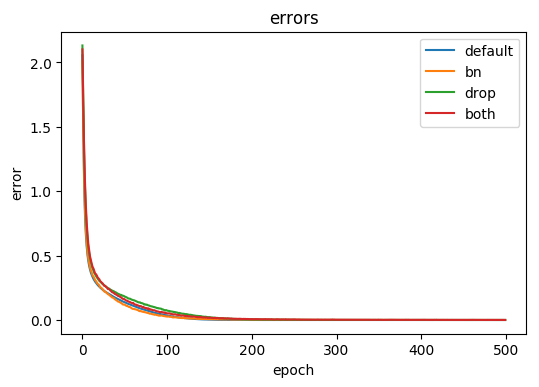

In [254]:
plot_graphs(train_log, 'loss')

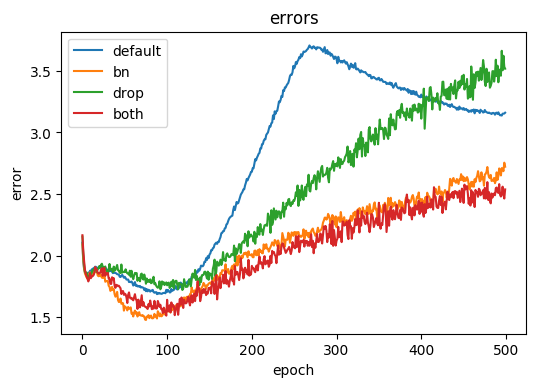

In [255]:
plot_graphs(test_log, 'loss')

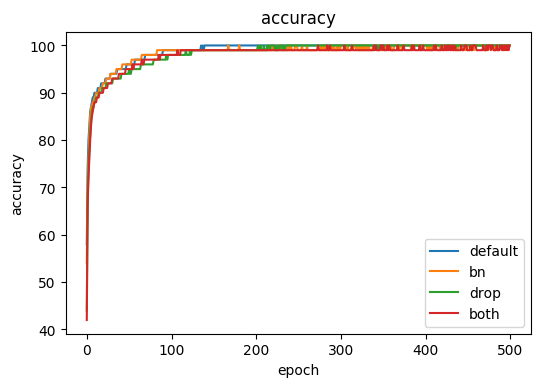

In [256]:
plot_graphs(train_log, 'accuracy')

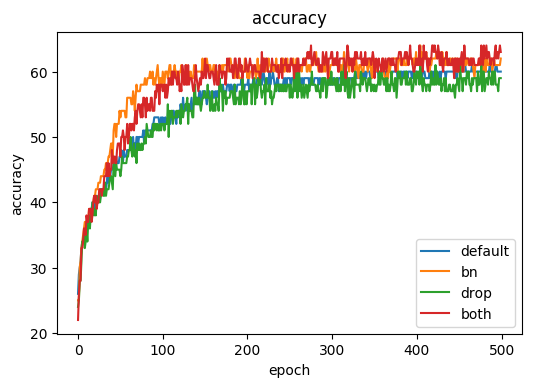

In [257]:
plot_graphs(test_log, 'accuracy')